In [1]:
import numpy 
import matplotlib.pyplot as plt
import h5py
import matplotlib.colors as colors
from scipy.interpolate import UnivariateSpline
from scipy import interpolate
import scipy.stats
import itertools
import wquantiles as wq

In [2]:
def find_contours_2D(x_values,y_values,xbins,weights=None,c1=16,c2=84):
    """
    Find upper and lower contours and median
    x_values = array, input for hist2d for x axis (typically truth)
    y_values = array, input for hist2d for y axis (typically reconstruction)
    xbins = values for the starting edge of the x bins (output from hist2d)
    c1 = percentage for lower contour bound (16% - 84% means a 68% band, so c1 = 16)
    c2 = percentage for upper contour bound (16% - 84% means a 68% band, so c2=84)
    Returns:
        x = values for xbins, repeated for plotting (i.e. [0,0,1,1,2,2,...]
        y_median = values for y value medians per bin, repeated for plotting (i.e. [40,40,20,20,50,50,...]
        y_lower = values for y value lower limits per bin, repeated for plotting (i.e. [30,30,10,10,20,20,...]
        y_upper = values for y value upper limits per bin, repeated for plotting (i.e. [50,50,40,40,60,60,...]
    """
    y_values = numpy.array(y_values)
    indices = numpy.digitize(x_values,xbins)
    r1_save = []
    r2_save = []
    median_save = []
    for i in range(1,len(xbins)):
        mask = indices==i
        if len(y_values[mask])>0:
            if weights is None:
                r1, m, r2 = numpy.percentile(y_values[mask],[c1,50,c2])
            else:
                r1 = wq.quantile(y_values[mask],weights[mask],c1/100.)
                r2 = wq.quantile(y_values[mask],weights[mask],c2/100.)
                m = wq.median(y_values[mask],weights[mask])
                
        else:
            print(i,'empty bin')
            r1 = 0
            m = 0
            r2 = 0
        median_save.append(m)
        r1_save.append(r1)
        r2_save.append(r2)
    median = numpy.array(median_save)
    lower = numpy.array(r1_save)
    upper = numpy.array(r2_save)

    x = list(itertools.chain(*zip(xbins[:-1],xbins[1:])))
    y_median = list(itertools.chain(*zip(median,median)))
    y_lower = list(itertools.chain(*zip(lower,lower)))
    y_upper = list(itertools.chain(*zip(upper,upper)))

    return x, y_median, y_lower, y_upper

In [3]:
def get_RMS(resolution,weights=None):
    mean_array = numpy.ones_like(resolution)*numpy.mean(resolution)
    if weights is None:
        rms = numpy.sqrt( sum((mean_array - resolution)**2)/len(resolution) )
    else:
        rms = numpy.zeros_like(resolution)
        rms = numpy.sqrt( sum(weights*(mean_array - resolution)**2)/sum(weights) )
    return rms

In [4]:
def weighted_avg_and_std(values, weights):
    """
    Return the weighted average and standard deviation.

    values, weights -- Numpy ndarrays with the same shape.
    """
    average = numpy.average(values, weights=weights)
    # Fast and numerically precise:
    variance = numpy.average((values-average)**2, weights=weights)
    return (average, math.sqrt(variance))

In [5]:
def plot_2D_prediction_weight(truth, nn_reco, weights=None, \
                        save=False,savefolder=None,syst_set="",\
                        bins=60,minval=None,maxval=None,\
                        cut_truth = False, axis_square =False, zmax=None,log=True,
                        variable="Energy", units = "(GeV)", epochs=None,reco_name="CNN"):
    maxplotline = min([max(nn_reco),max(truth)])
    minplotline = max([min(nn_reco),min(truth)])

    truth = truth #[mask]
    nn_reco = nn_reco #[mask]

    #Cut axis
    if axis_square:
        xmin = minval
        ymin = minval
        xmax = maxval
        ymax = maxval
    else:
        xmin = min(truth)
        ymin = min(nn_reco)
        xmax = max(truth)
        ymax = max(nn_reco)

    plt.figure(figsize=(10,7))
    if weights is None:
        cmin = 1
    else:
        cmin = 1e-12
    if log:
        cts,xbin,ybin,img = plt.hist2d(truth, nn_reco, bins=bins,range=[[xmin,xmax],[ymin,ymax]],\
                        cmap='viridis_r', norm=colors.LogNorm(), weights=weights, vmax=zmax, cmin=cmin)
    else:
        cts,xbin,ybin,img = plt.hist2d(truth, nn_reco, bins=bins,range=[[xmin,xmax],[ymin,ymax]],\
                        cmap='viridis_r', weights=weights, vmax=zmax, cmin=cmin)
    cbar = plt.colorbar()
    cbar.ax.set_ylabel('counts', rotation=90)
    plt.xlabel("True Neutrino %s %s"%(variable,units),fontsize=20)
    plt.ylabel("%s Reconstructed %s %s"%(reco_name,variable,units),fontsize=20)
    title = "%s vs Truth for %s %s"%(reco_name,variable,syst_set)
    if weights is not None:
        title += "Weighted"
    if epochs:
        title += " at %i Epochs"%epochs
    plt.suptitle(title,fontsize=25)
    #if cutting:
    #    plt.title("%s, plotted %i, overflow %i"%(name,len(truth),overflow),fontsize=20)

    #Plot 1:1 line
    if axis_square:
        plt.plot([minval,maxval],[minval,maxval],'k:', label="1:1")
    else:
        plt.plot([minplotline,maxplotline],[minplotline,maxplotline],'k:', label="1:1")

    x, y, y_l, y_u = find_contours_2D(truth,nn_reco,xbin,weights=weights)
    plt.plot(x,y,color='r',label='Median')
    plt.plot(x,y_l,color='r',label='68% band',linestyle='dashed')
    plt.plot(x,y_u,color='r',linestyle='dashed')
    plt.legend(fontsize=20)

    reco_name = reco_name.replace(" ","")
    variable = variable.replace(" ","")
    nocut_name = ""
    if weights is not None:
        nocut_name="Weighted"
    if not axis_square:
        nocut_name ="_nolim"
    if zmax:
        nocut_name += "_zmax%i"%zmax
    if save:
        plt.savefig("%sTruth%sReco%s_2DHist%s%s.png"%(savefolder,reco_name,variable,syst_set,nocut_name),bbox_inches='tight')
    plt.show()


In [6]:
def plot_single_resolution(truth,nn_reco,weights=None, \
                           bins=100, use_fraction=False,\
                           use_old_reco = False, old_reco=None,old_reco_truth=None,\
                           mintrue=None,maxtrue=None,\
                           minaxis=None,maxaxis=None,\
                           save=False,savefolder=None,
                           variable="Energy", units = "GeV", epochs=None,reco_name="CNN"):
    """Plots resolution for dict of inputs, one of which will be a second reco
    Recieves:
        truth = array of truth or Y_test labels
        nn_reco = array of NN predicted reco or Y_test_predicted results
        bins = int value
        use_fraction = use fractional resolution instead of absolute, where (reco - truth)/truth
        use_old_reco = True if you want to compare to another reconstruction (like pegleg)
        old_reco = optional, pegleg array of labels
        mintrue = float, min true value if cut desired
        maxtrue = float, max true value if cut desired
        minaxis = float, min x axis cut
        maxaxis = float, max x axis cut
    Returns:
        1D histogram of Reco - True (or fractional)
        Can have two distributions of NN Reco Resolution vs Pegleg Reco Resolution
    """

    fig, ax = plt.subplots(figsize=(10,7))

    ## Assume old_reco truth is the same as test sample, option to set it otherwise
    if old_reco_truth is None:
        truth2 = truth
    else:
        truth2 = old_reco_truth
    weights_reco = weights 
    
    if use_fraction:
        nn_resolution = (nn_reco - truth)/truth
        if use_old_reco:
            old_reco_resolution = (old_reco - truth2)/truth2
        title = "Fractional %s Resolution"%variable
        xlabel = r'$\frac{reconstruction - truth}{truth}$'
    else:
        nn_resolution = nn_reco - truth
        if use_old_reco:
            old_reco_resolution = old_reco - truth2
        title = "%s Resolution"%variable
        xlabel = "reconstruction - truth %s"%units
    if epochs:
        title += " at %i Epochs"%epochs
    if weights is not None:
        title += " Weighted"
    original_size = len(nn_resolution)
 
    # Cut on true values
    #print(mintrue,maxtrue)
    if mintrue or maxtrue:
         truth_cut=True
    else:
         truth_cut=False
    if not mintrue:
        mintrue = int(min(truth))
    if not maxtrue:
        maxtrue = int(max(truth))+1
    #print(mintrue,maxtrue,truth_cut)
    if truth_cut:
        true_mask = numpy.logical_and(truth >= mintrue, truth <= maxtrue)
        title += "\n(true %s [%.2f, %.2f])"%(variable,mintrue,maxtrue)
        nn_resolution = nn_resolution[true_mask]
        weights = weights[true_mask]
        if use_old_reco:
            true2_mask = numpy.logical_and(truth2 >= mintrue, truth2 <= maxtrue)
            old_reco_resolution = old_reco_resolution[true2_mask]
            weights_reco = weights_reco[true2_mask]
    true_cut_size=len(nn_resolution)
    
    
    #Get stats before axis cut!
    rms_nn = get_RMS(nn_resolution,weights)
    if weights is not None:
        r1 = wq.quantile(nn_resolution,weights,0.16)
        r2 = wq.quantile(nn_resolution,weights,0.84)
        median = wq.median(nn_resolution,weights)
    else:
        r1, r2 = numpy.percentile(nn_resolution, [16,84])
        median = numpy.median(nn_resolution)
    if use_old_reco:
        true_cut_size_reco=len(old_reco_resolution)
        rms_old_reco = get_RMS(old_reco_resolution,weights_reco)
        if weights is not None:
            r1_old_reco = wq.quantile(old_reco_resolution,weights_reco,0.16)
            r2_old_reco = wq.quantile(old_reco_resolution,weights_reco,0.84)
            median_old_reco = wq.median(nn_resolution,weights_reco)
        else:
            r1_old_reco, r2_old_reco = numpy.percentile(old_reco_resolution, [16,84])
            median_old_reco = numpy.median(old_reco_resolution)


    # Cut for plot axis
    #print(minaxis,maxaxis)
    if minaxis or maxaxis:
        axis_cut=True
    else:
        axis_cut=False
    if not minaxis:
        axis_cut=True
        minaxis = min(nn_resolution)
        if use_old_reco:
            if minaxis > min(old_reco_resolution):
                    minaxis = min(old_reco_resolution)
    if not maxaxis:
        axis_cut=True
        maxaxis = max(nn_resolution)
        if use_old_reco:
            if maxaxis < max(old_reco_resolution):
                    maxaxis = max(old_reco_resolution)
    if axis_cut:
        axis_mask = numpy.logical_and(nn_resolution >= minaxis, nn_resolution <= maxaxis)
        nn_resolution = nn_resolution[axis_mask]
        weights = weights[axis_mask]
        if use_old_reco:
            reco_axis_mask = numpy.logical_and(old_reco_resolution >= minaxis, old_reco_resolution <= maxaxis)
            old_reco_resolution = old_reco_resolution[reco_axis_mask]
            reco_len = len(old_reco_resolution)
            weights_reco = weights_reco[reco_axis_mask]
           
    true_axis_cut_size=len(nn_resolution)

    cnn_name = "Neural Network"
    #cnn_name = "CNN"
    hist_nn, bins, p = ax.hist(nn_resolution, bins=bins, range=[minaxis,maxaxis], weights=weights, alpha=0.5, label=cnn_name);
    if use_old_reco:
        stats1_label = cnn_name
        
    else:
        stats1_label = reco_name

    #Statistics
    #weighted_avg_and_std(nn_resolution,weights)
    
    textstr = '\n'.join((
            r'%s' % (stats1_label),
            r'$\mathrm{events}=%i$' % (len(nn_resolution), ),
            r'$\mathrm{median}=%.2f$' % (median, ),
            r'$\mathrm{overflow}=%i$' % (true_cut_size-true_axis_cut_size, ),
            r'$\mathrm{RMS}=%.2f$' % (rms_nn, ),
            r'$\mathrm{1\sigma}=%.2f,%.2f$' % (r1,r2 )))
    props = dict(boxstyle='round', facecolor='blue', alpha=0.3)
    ax.text(0.6, 0.95, textstr, transform=ax.transAxes, fontsize=20,
        verticalalignment='top', bbox=props)

    if use_old_reco:
        ax.hist(old_reco_resolution, bins=bins, range=[minaxis,maxaxis], weights=weights_reco, alpha=0.5, label="%s"%reco_name);
        ax.legend(loc="upper left",fontsize=20)
        textstr = '\n'.join((
            '%s' % (reco_name),
            r'$\mathrm{events}=%i$' % (len(old_reco_resolution), ),
            r'$\mathrm{median}=%.2f$' % (median_old_reco, ),
            r'$\mathrm{overflow}=%i$' % (true_cut_size_reco-reco_len, ),
            r'$\mathrm{RMS}=%.2f$' % (rms_old_reco, ),
            r'$\mathrm{1\sigma}=%.2f,%.2f$' % (r1_old_reco,r2_old_reco )))
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
        ax.text(0.6, 0.55, textstr, transform=ax.transAxes, fontsize=20,
            verticalalignment='top', bbox=props)

    #if axis_cut:
    ax.set_xlim(minaxis,maxaxis)
    ax.set_xlabel(xlabel,fontsize=20)
    ax.set_title(title,fontsize=25)

    reco_name = reco_name.replace(" ","")
    variable = variable.replace(" ","")
    savename = "%sResolution"%variable
    if weights is not None:
        savename+="Weighted"
    if use_fraction:
        savename += "Frac"
    if truth_cut:
        savename = "_Range%.2f_%.2f"%(mintrue,maxtrue)
    if use_old_reco:
        savename += "_Compare%sReco"%reco_name
    if axis_cut:
        savename += "_xlim"
    if save == True:
        plt.savefig("%s%s.png"%(savefolder,savename),bbox_inches='tight')
    plt.show()


In [7]:
def plot_distributions(truth,reco,save=False,savefolder=None,weights=None,old_reco=None,reco_name="",variable="Energy",units="(GeV)"):
    """
    Plot testing set distribution
    Recieves:
        truth = array, Y_test truth labels
        reco = array, neural network prediction output
        save = optional, bool to save plot
        savefolder = optional, output folder to save to, if not in current dir
        variable = string, variable name
        units = string, units for variable
    Returns:
        1D histogram of variable's absolute distribution for truth and for reco overlaid
    """
    given_max=100
    given_min = 0
    max_range = numpy.max([numpy.max(truth),numpy.max(reco)])
    min_range = numpy.min([numpy.min(truth),numpy.min(reco)])
    plt.figure(figsize=(10,7))
    title="%s Distribution"%variable
    if weights is not None:
        title = "Weighted %s Distribution"%variable
    plt.title(title,fontsize=25)
    keep_true = numpy.logical_and(truth>min_range,truth<max_range)
    keep_reco = numpy.logical_and(reco>min_range,reco<max_range)
    keep_old_reco = numpy.logical_and(old_reco>min_range,old_reco<max_range)
    
    plt.hist(truth, bins=100,color='red',alpha=0.5,range=[min_range,max_range],weights=weights,label="Truth");
    plt.hist(reco, bins=100,color='b', alpha=0.5,range=[min_range,max_range],weights=weights,label="NN Reco");
    if old_reco is not None:
        plt.hist(old_reco, bins=100,color='g', alpha=0.5,range=[min_range,max_range],weights=weights,label="%s"%reco_name);
    plt.xlabel("%s %s"%(variable,units),fontsize=20)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.legend(fontsize=20)
    savename = title.replace(" ","")
    if old_reco is not None:
        savename+="_%s"%(reco_name.replace(" ",""))
    if save:
        plt.savefig("%s%s%s.png"%(savefolder,variable,savename))
    plt.show()

In [8]:
def plot_bin_slices(truth, nn_reco, energy_truth=None, weights=None,\
                       use_fraction = False, old_reco=None,old_reco_truth=None, reco_energy_truth=None,\
                       bins=10,min_val=0.,max_val=60., ylim = None,\
                       save=False,savefolder=None,vs_predict=False,\
                       variable="Energy",units="(GeV)",epochs=None,reco_name="PegLeg"):
    """Plots different variable slices vs each other (systematic set arrays)
    Receives:
        truth= array with truth labels for this one variable
        nn_reco = array that has NN predicted reco results for one variable (same size of truth)
        energy_truth = optional (will use if given), array that has true energy information (same size of truth)
        use_fraction = bool, use fractional resolution instead of absolute, where (reco - truth)/truth
        old_reco = optional (will use if given), array of pegleg labels for one variable
        bins = integer number of data points you want (range/bins = width)
        min_val = minimum value for variable to start cut at (default = 0.)
        max_val = maximum value for variable to end cut at (default = 60.)
        ylim = List with two entries of ymin and ymax for plot [min, max], leave as None for no ylim applied
    Returns:
        Scatter plot with energy values on x axis (median of bin width)
        y axis has median of resolution with error bars containing 68% of resolution
    """
    nn_reco = numpy.array(nn_reco)
    truth = numpy.array(truth)
     ## Assume old_reco truth is the same as test sample, option to set it otherwise
    if old_reco_truth is None:
        truth2 = numpy.array(truth)
    else:
        truth2 = numpy.array(old_reco_truth)
    if reco_energy_truth is None:
        energy_truth2 = numpy.array(energy_truth)
    else:
        energy_truth2 = numpy.array(reco_energy_truth)

    if use_fraction:
        resolution = ((nn_reco-truth)/truth) # in fraction
    else:
        resolution = (nn_reco-truth)
    resolution = numpy.array(resolution)
    percentile_in_peak = 68.27

    left_tail_percentile  = (100.-percentile_in_peak)/2
    right_tail_percentile = 100.-left_tail_percentile

    variable_ranges  = numpy.linspace(min_val,max_val, num=bins+1)
    variable_centers = (variable_ranges[1:] + variable_ranges[:-1])/2.

    medians  = numpy.zeros(len(variable_centers))
    err_from = numpy.zeros(len(variable_centers))
    err_to   = numpy.zeros(len(variable_centers))

    if old_reco is not None:
        if use_fraction:
            resolution_reco = ((old_reco-truth2)/truth2)
        else:
            resolution_reco = (old_reco-truth2)
        resolution_reco = numpy.array(resolution_reco)
        medians_reco  = numpy.zeros(len(variable_centers))
        err_from_reco = numpy.zeros(len(variable_centers))
        err_to_reco   = numpy.zeros(len(variable_centers))

    for i in range(len(variable_ranges)-1):
        var_from = variable_ranges[i]
        var_to   = variable_ranges[i+1]
        
        if vs_predict:
            x_axis_array = nn_reco
            x_axis_array2 = nn_reco
            title="%s Resolution Dependence"%(variable)
        else:
            if energy_truth is None:
                title="%s Resolution Dependence"%(variable)
                x_axis_array = truth
                x_axis_array2 = truth2
            else:
                title="%s Resolution Energy Dependence"%(variable)
                energy_truth = numpy.array(energy_truth)
                x_axis_array = energy_truth
                x_axis_array2 = energy_truth2
                
        cut = (x_axis_array >= var_from) & (x_axis_array < var_to)
        cut2 = (x_axis_array2 >= var_from) & (x_axis_array2 < var_to)

        if weights is not None:
            lower_lim = wq.quantile(resolution[cut],weights[cut],0.16)
            upper_lim = wq.quantile(resolution[cut],weights[cut],0.84)
            median = wq.median(resolution[cut],weights[cut])
        else:
            lower_lim = numpy.percentile(resolution[cut], left_tail_percentile)
            upper_lim = numpy.percentile(resolution[cut], right_tail_percentile)
            median = numpy.percentile(resolution[cut], 50.)

        medians[i] = median
        err_from[i] = lower_lim
        err_to[i] = upper_lim

        if old_reco is not None:
            if weights is not None:
                lower_lim_reco = wq.quantile(resolution_reco[cut2],weights[cut2],0.16)
                upper_lim_reco = wq.quantile(resolution_reco[cut2],weights[cut2],0.84)
                median_reco = wq.median(resolution_reco[cut2],weights[cut2])
            else:
                lower_lim_reco = numpy.percentile(resolution_reco[cut2], left_tail_percentile)
                upper_lim_reco = numpy.percentile(resolution_reco[cut2], right_tail_percentile)
                median_reco = numpy.percentile(resolution_reco[cut2], 50.)

            medians_reco[i] = median_reco
            err_from_reco[i] = lower_lim_reco
            err_to_reco[i] = upper_lim_reco

    cnn_name = "CNN"
    #cnn_name = "Neural Network"
    plt.figure(figsize=(10,7))
    plt.errorbar(variable_centers, medians, yerr=[medians-err_from, err_to-medians], xerr=[ variable_centers-variable_ranges[:-1], variable_ranges[1:]-variable_centers ], capsize=5.0, fmt='o',label=cnn_name)
    if old_reco is not None:
        plt.errorbar(variable_centers, medians_reco, yerr=[medians_reco-err_from_reco, err_to_reco-medians_reco], xerr=[ variable_centers-variable_ranges[:-1], variable_ranges[1:]-variable_centers ], capsize=5.0, fmt='o',label="%s"%reco_name)
        plt.legend(loc="upper center")
    plt.plot([min_val,max_val], [0,0], color='k')
    plt.xlim(min_val,max_val)
    if type(ylim) is not None:
        plt.ylim(ylim)
    if vs_predict:
        plt.xlabel("CNN Predicted %s %s"%(variable,units),fontsize=20)
    else:
        plt.xlabel("True %s %s"%(variable,units),fontsize=20)
    if use_fraction:
        plt.ylabel(r'Fractional Resolution: $\frac{reconstruction - truth}{truth}$',fontsize=20)
    else:
         plt.ylabel("Resolution: \n reconstruction - truth %s"%units,fontsize=20)
    #if epochs:
    #    title += " at %i Epochs"%epochs
    plt.title(title,fontsize=25)
    
    reco_name = reco_name.replace(" ","")
    variable = variable.replace(" ","")
    savename = "%sResolutionSlices"%variable
    if use_fraction:
        savename += "Frac"
    if energy_truth is not None:
        savename += "_EnergyBinned"
        plt.xlabel("True Energy (GeV)",fontsize=20)
    if old_reco is not None:
        savename += "_Compare%sReco"%reco_name
    if type(ylim) is not None:
        savename += "_ylim"
    if save == True:
        plt.savefig("%s%s.png"%(savefolder,savename))
    plt.show()


In [9]:
def plot_rms_slices(truth, nn_reco, energy_truth=None, \
                       use_fraction = False, old_reco=None,old_reco_truth=None, reco_energy_truth=None,\
                       bins=10,min_val=0.,max_val=60., ylim = None,weights=None,\
                       save=False,savefolder=None,use_rms=False,\
                       variable="Energy",units="(GeV)",epochs=None,reco_name="PegLeg"):
    """Plots different variable slices vs each other (systematic set arrays)
    Receives:
        truth= array with truth labels for this one variable
        nn_reco = array that has NN predicted reco results for one variable (same size of truth)
        energy_truth = optional (will use if given), array that has true energy information (same size of truth)
        use_fraction = bool, use fractional resolution instead of absolute, where (reco - truth)/truth
        old_reco = optional (will use if given), array of pegleg labels for one variable
        bins = integer number of data points you want (range/bins = width)
        min_val = minimum value for variable to start cut at (default = 0.)
        max_val = maximum value for variable to end cut at (default = 60.)
        ylim = List with two entries of ymin and ymax for plot [min, max], leave as None for no ylim applied
    Returns:
        Scatter plot with energy values on x axis (median of bin width)
        y axis has median of resolution with error bars containing 68% of resolution
    """
    nn_reco = numpy.array(nn_reco)
    truth = numpy.array(truth)
     ## Assume old_reco truth is the same as test sample, option to set it otherwise
    if old_reco_truth is None:
        truth2 = numpy.array(truth)
    else:
        truth2 = numpy.array(old_reco_truth)
    if reco_energy_truth is None:
        energy_truth2 = numpy.array(energy_truth)
    else:
        energy_truth2 = numpy.array(reco_energy_truth)

    if use_fraction:
        resolution = ((nn_reco-truth)/truth) # in fraction
    else:
        resolution = (nn_reco-truth)
    resolution = numpy.array(resolution)

    variable_ranges  = numpy.linspace(min_val,max_val, num=bins+1)
    variable_centers = (variable_ranges[1:] + variable_ranges[:-1])/2.

    rms_all  = numpy.zeros(len(variable_centers))

    if old_reco is not None:
        if use_fraction:
            resolution_reco = ((old_reco-truth2)/truth2)
        else:
            resolution_reco = (old_reco-truth2)
        resolution_reco = numpy.array(resolution_reco)
        rms_reco_all = numpy.zeros(len(variable_centers))

    for i in range(len(variable_ranges)-1):
        var_from = variable_ranges[i]
        var_to   = variable_ranges[i+1]
        
        
        if weights is None:
            title=""
        else:
            title="Weighted "
        if energy_truth is None:
            title+="%s RMS Resolution Dependence"%(variable)
            cut = (truth >= var_from) & (truth < var_to)
            cut2 = (truth2 >= var_from) & (truth2 < var_to)
        else:
            #print("Using energy for x-axis. Make sure your min_val and max_val are in terms of energy!")
            title+="%s RMS Resolution Energy Dependence"%(variable)
            energy_truth = numpy.array(energy_truth)
            cut = (energy_truth >= var_from) & (energy_truth < var_to)
            cut2 = (energy_truth2 >= var_from) & (energy_truth2 < var_to)
        
        
        if weights is not None:
            weight_here = weights[cut]
        else:
            weight_here = None
        rms = get_RMS(resolution[cut],weight_here)
        rms_all[i] = rms
       
        if old_reco is not None:
            rms_reco = get_RMS(resolution_reco[cut],weight_here)
            rms_reco_all[i] = rms_reco

    #cnn_name = "CNN"
    cnn_name = "Neural Network Reconstruction"
    diff_width=abs(variable_ranges[1] - variable_ranges[0])
    plt.figure(figsize=(10,7))

    if old_reco is not None:
        rms_reco_all = numpy.append(rms_reco_all, rms_reco_all[-1])
        plt.step(variable_ranges, rms_reco_all, where='post', color="orange",label="%s"%reco_name)
    rms_all = numpy.append(rms_all,rms_all[-1])
    plt.step(variable_ranges, rms_all, where='post', color="blue",label=cnn_name)
    plt.legend(fontsize=20)
    
    
    plt.ylim(bottom=0)
    plt.xlim(min_val,max_val)
    if type(ylim) is not None:
        plt.ylim(ylim)
    plt.xlabel("True %s %s"%(variable,units),fontsize=20)
    if use_fraction:
        if weights is not None:
            plt.ylabel(r'Weighted RMS of Fractional Resoltion: $\frac{reconstruction - truth}{truth}$',fontsize=20)
        else:
            plt.ylabel(r'RMS of Fractional Resoltion: $\frac{reconstruction - truth}{truth}$',fontsize=20)
    else:
        if weights is not None:
            plt.ylabel("Weighted RMS of Resolution: \n reconstruction - truth %s"%units,fontsize=20)
        else:
            plt.ylabel("RMS of Resolution: \n reconstruction - truth %s"%units,fontsize=20)
    #plt.ylabel("RMS resolution of cosine(zenith)",fontsize=20)
    #plt.xlabel("true neutrino energy (GeV)",fontsize=20)
    #title="Angular Resolution (contained neutrino events)"
    #plt.xticks(fontsize=20)
    #plt.yticks(fontsize=20)
    #if epochs:
    #    title += " at %i Epochs"%epochs
    plt.title(title,fontsize=20)
    
    print(rms_all,rms_reco_all)
    
    reco_name = reco_name.replace(" ","")
    variable = variable.replace(" ","")
    savename = "%sRMSSlices"%variable
    if use_fraction:
        savename += "Frac"
    if weights is not None:
        savename += "Weighted"
    if energy_truth is not None:
        savename += "_EnergyBinned"
        plt.xlabel("True Energy (GeV)",fontsize=20)
    if old_reco is not None:
        savename += "_Compare%sReco"%reco_name
    if type(ylim) is not None:
        savename += "_ylim"
    if save == True:
        plt.savefig("%s%s.png"%(savefolder,savename))
    plt.show()


In [10]:
model="zenith_numu_flat_5_150_CC_26659evtperbin_IC19_oldstartDC_lrEpochs50"
test_name="retro_nue4_152epochs"
label="Likelihood Reconstruction"

variable="Cosine Zenith"

if variable == "Cosine Zenith":
    units=""
    true_index = 1
    reco_index = 0
    old_reco_index = 1
    minval = -1
    minval2 = -1
    maxval = 1
    print("ZENITH")
elif variable == "Energy":
    units="(GeV)"
    true_index = 0
    reco_index = 0
    old_reco_index = 0
    minval = 5
    minval2 = -100
    maxval = 100
    print("ENERGY")
zmax = 3e-7

path="/home/users/jmicallef/LowEnergyNeuralNetwork/output_plots/%s/%s/"%(model,test_name)
filename="prediction_values.hdf5"
f = h5py.File(path+filename,"r")
truth = f["Y_test_use"][:]
predict = f["Y_predicted"][:]
reco = f["reco_test"][:]
weights = f["weights_test"][:]
f.close()
NumberFiles=387.
truth[:,0] = truth[:,0]*100.
if variable == "Energy":
    predict[:,0] = predict[:,0]*100.
#reco[:,1] = numpy.cos(reco[:,1])
final_weights = weights[:,8]/NumberFiles

ZENITH


In [12]:
true_energy_mask = numpy.logical_and(truth[:,0]>5.,truth[:,0]<100.)
truth = truth[true_energy_mask]
predict = predict[true_energy_mask]
reco = reco[true_energy_mask]
final_weights = final_weights[true_energy_mask]

In [9]:
mask_anti = truth[:,10] ==1
mask_nu = truth[:,10] ==0
print(sum(mask_anti)+sum(mask_nu),truth.shape)
w2 = numpy.zeros((weights.shape[0]))
w2[mask_nu] = weights[mask_nu][:,4]/(weights[mask_nu][:,3]*0.7*NumberFiles)
w2[mask_anti] = weights[mask_anti][:,4]/(weights[mask_anti][:,3]*0.3*NumberFiles)


520989 (520989, 12)


[2.65245955 2.68104783 2.69226482 2.71606126 2.70238102 2.71221839
 2.73438782 2.70847092 2.72248925 2.75037546 2.75037546] [14.54490098 15.6666419  25.51912887 26.11946177 35.44651249 22.82451637
 30.19019743 45.88454617 29.91786479 33.67529023 33.67529023]


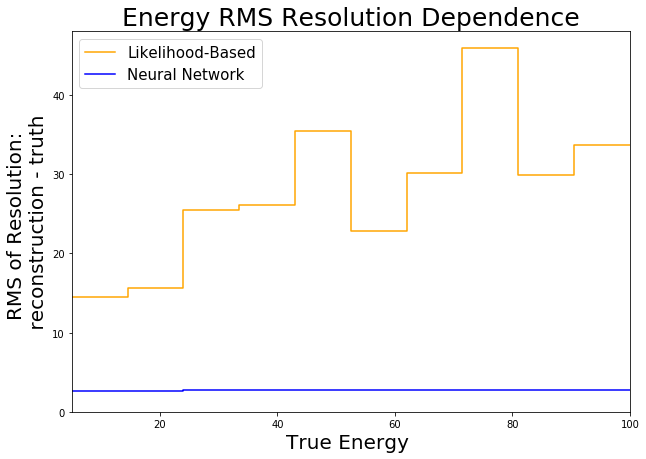

In [16]:
plot_rms_slices(truth[:,true_index], predict[:,reco_index], energy_truth=None, \
                       use_fraction = False, old_reco=reco[:,old_reco_index],old_reco_truth=truth[:,true_index],\
                       bins=10,min_val=minval,max_val=maxval, ylim = None,\
                       save=True,savefolder=path,\
                       variable=variable,units=units,epochs=None,reco_name=label)

[0.37385078 0.35947419 0.34102426 0.32824654 0.31656544 0.29500634
 0.29500104 0.2922942  0.27702172 0.27292129 0.26310922 0.26310922] [0.45282616 0.43443173 0.40984594 0.38278804 0.36963092 0.34484365
 0.31568472 0.30426439 0.29633981 0.27256849 0.2850009  0.2850009 ]


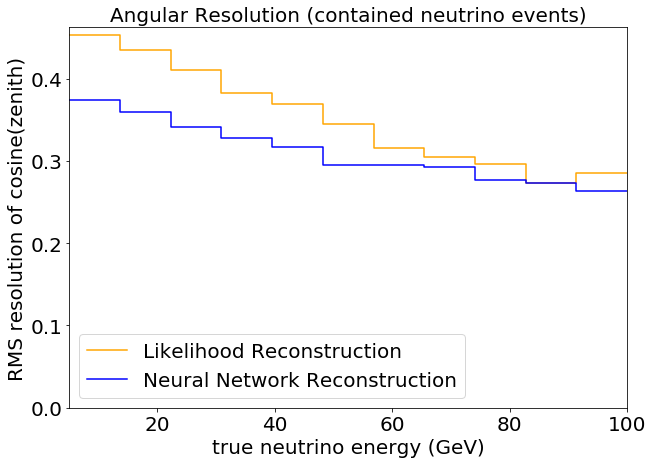

In [13]:
plot_rms_slices(truth[:,true_index], predict[:,reco_index], energy_truth=truth[:,0], \
                       use_fraction = False, old_reco=reco[:,old_reco_index],old_reco_truth=truth[:,true_index],\
                       bins=11,min_val=5.,max_val=100., ylim = None,weights=final_weights,\
                       save=True,savefolder=path,\
                       variable=variable,units=units,epochs=None,reco_name=label)

[ 3.65343964  6.71028445  9.52510011 11.95654637 13.84610787 15.95758273
 17.64470844 18.90122997 20.39886364 21.43455582 22.2207123  22.2207123 ] [15.74792396 15.8374548  23.85026739 20.07804454 31.28037048 33.31591353
 31.58622856 26.13812842 42.89909624 30.10540694 33.14373213 33.14373213]


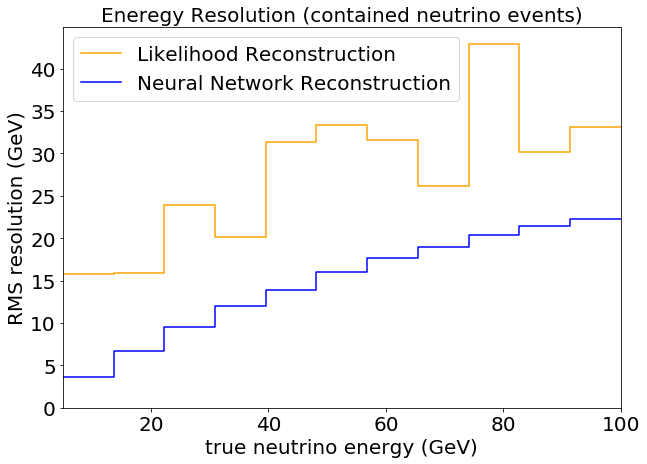

In [56]:
plot_rms_slices(truth[:,true_index], predict[:,reco_index], \
                       use_fraction = False, old_reco=reco[:,old_reco_index],old_reco_truth=truth[:,true_index],\
                       bins=11,min_val=minval,max_val=maxval, ylim = None,weights=final_weights,\
                       save=True,savefolder=path,\
                       variable=variable,units=units,epochs=None,reco_name=label)

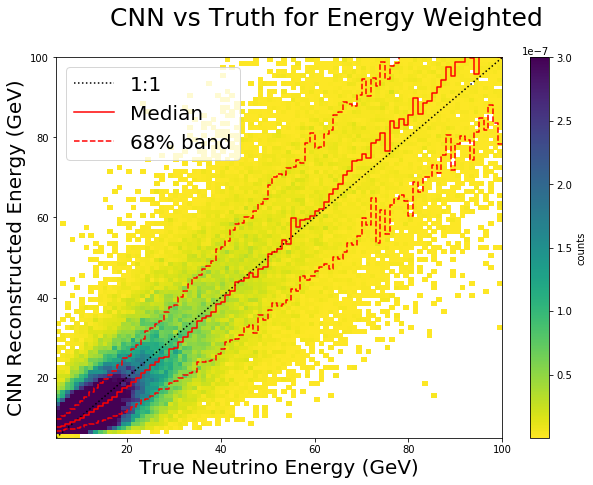

In [39]:
plot_2D_prediction_weight(truth[:,true_index], predict[:,reco_index], weights=final_weights, \
                        save=True,savefolder=path,syst_set="",\
                        bins=95,minval=minval,maxval=maxval,\
                        cut_truth = False, axis_square = True, zmax=zmax,log=False,
                        variable=variable, units = units, epochs=None,reco_name="CNN")

#plot_2D_prediction_weight(truth[:,true_index], predict[:,reco_index], weights=w2, \
#                        save=True,savefolder=path,syst_set="",\
#                        bins=95,minval=5,maxval=100.,\
#                        cut_truth = False, axis_square = True, zmax=None,log=False,
#                        variable=variable, units = units, epochs=None,reco_name="CNN")

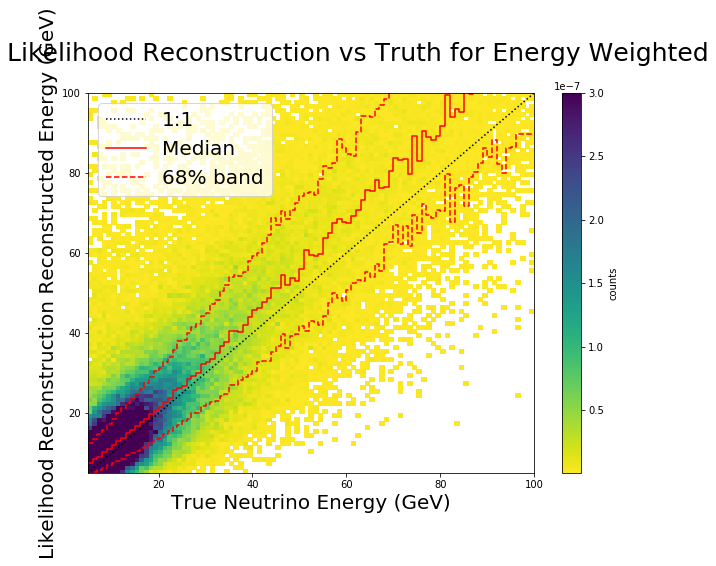

In [24]:
plot_2D_prediction_weight(truth[:,true_index], reco[:,old_reco_index], weights=final_weights, \
                        save=True,savefolder=path,syst_set="",\
                        bins=95,minval=minval,maxval=maxval,\
                        cut_truth = False, axis_square = True, zmax=zmax,log=False,
                        variable=variable, units = units, epochs=None,reco_name=label)

#plot_2D_prediction_weight(truth[:,true_index], reco[:,old_reco_index], weights=w2, \
#                        save=True,savefolder=path,syst_set="",\
#                        bins=95,minval=5,maxval=100.,\
#                        cut_truth = False, axis_square = True, zmax=None,log=False,
#                        variable=variable, units = units, epochs=None,reco_name=label)

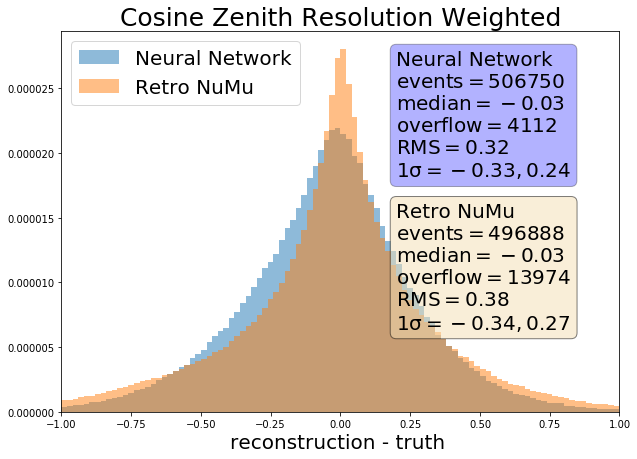

In [52]:
plot_single_resolution(truth[:,true_index],predict[:,reco_index],weights=final_weights, \
                           bins=100, use_fraction=False,\
                           use_old_reco = True, old_reco=reco[:,old_reco_index],old_reco_truth=truth[:,true_index],\
                           mintrue=None,maxtrue=None,\
                           minaxis=minval2,maxaxis=maxval,\
                           save=True,savefolder=path,
                           variable=variable, units = units, epochs=None,reco_name=label)

#plot_single_resolution(truth[:,true_index],predict[:,reco_index],weights=w2, \
#                           bins=100, use_fraction=False,\
#                           use_old_reco = True, old_reco=reco[:,old_reco_index],old_reco_truth=truth[:,true_index],\
#                           mintrue=None,maxtrue=None,\
#                           minaxis=-100,maxaxis=100,\
#                           save=True,savefolder=path,
#                           variable=variable, units = units, epochs=None,reco_name=label)

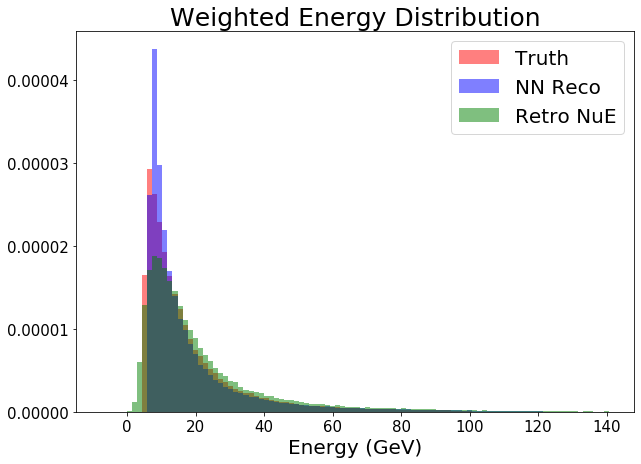

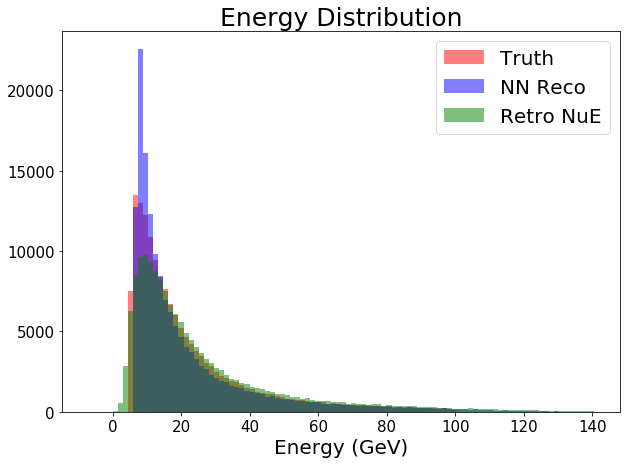

In [49]:
plot_distributions(truth[:,true_index],predict[:,reco_index],save=True,savefolder=path,weights=final_weights,old_reco=reco[:,old_reco_index],reco_name=label,variable=variable,units=units)
#plot_distributions(truth[:,true_index],predict[:,reco_index],save=True,savefolder=path,weights=w2,old_reco=reco[:,old_reco_index],reco_name=label,variable=variable,units=units)
plot_distributions(truth[:,true_index],predict[:,reco_index],save=True,savefolder=path,weights=None,old_reco=reco[:,old_reco_index],reco_name=label,variable=variable,units=units)

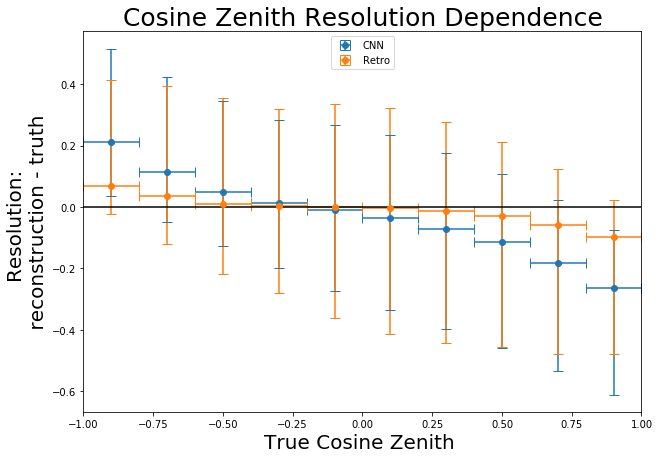

In [56]:
plot_bin_slices(truth[:,true_index],predict[:,reco_index], energy_truth=None, weights=final_weights,\
                       use_fraction = False, old_reco=reco[:,old_reco_index],old_reco_truth=truth[:,true_index], reco_energy_truth=None,\
                       bins=10,min_val=-1,max_val=1., ylim = None,\
                       save=False,savefolder=None,\
                       variable="Cosine Zenith",units="",epochs=None,reco_name="Retro")

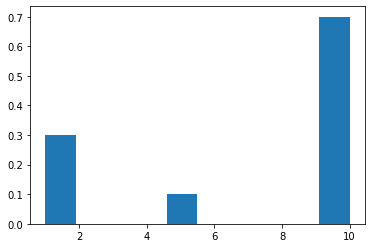

In [41]:
test_array=numpy.array([10,10,10,5,1,1,1])
test_weights = numpy.ones((7))*.1
test_weights[0] = .5
hist,bins,patch = plt.hist(test_array,weights=test_weights)
sum(hist)
#r1, r2 = numpy.percentile(nn_resolution, [16,84])
r1 = wq.quantile(test_array,test_weights,0.16)
r2 = wq.quantile(test_array,test_weights,0.84)
r3 = wq.median(test_array,test_weights)
#rmed = ws.median((test_array,test_weights))

In [42]:
print(r1,r3,r2)

1.0 8.333333333333334 10.0


In [43]:
r3 = numpy.median(test_array)
r1, r2 = numpy.percentile(test_array, [16,84])
print(r1,r3,r2)

1.0 5.0 10.0
